
Initializing dental segmentation...


100%|██████████| 2.56G/2.56G [00:35<00:00, 72.7MiB/s]
/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Starting image processing...
Found 1 images to process


Processing images:   0%|          | 0/1 [00:00<?, ?it/s]

Found 173 teeth in dental-x-ray-mesa-az.jpeg


Processing images: 100%|██████████| 1/1 [04:17<00:00, 257.80s/it]


Displaying processed images:

Displaying: segmented_dental-x-ray-mesa-az.jpeg


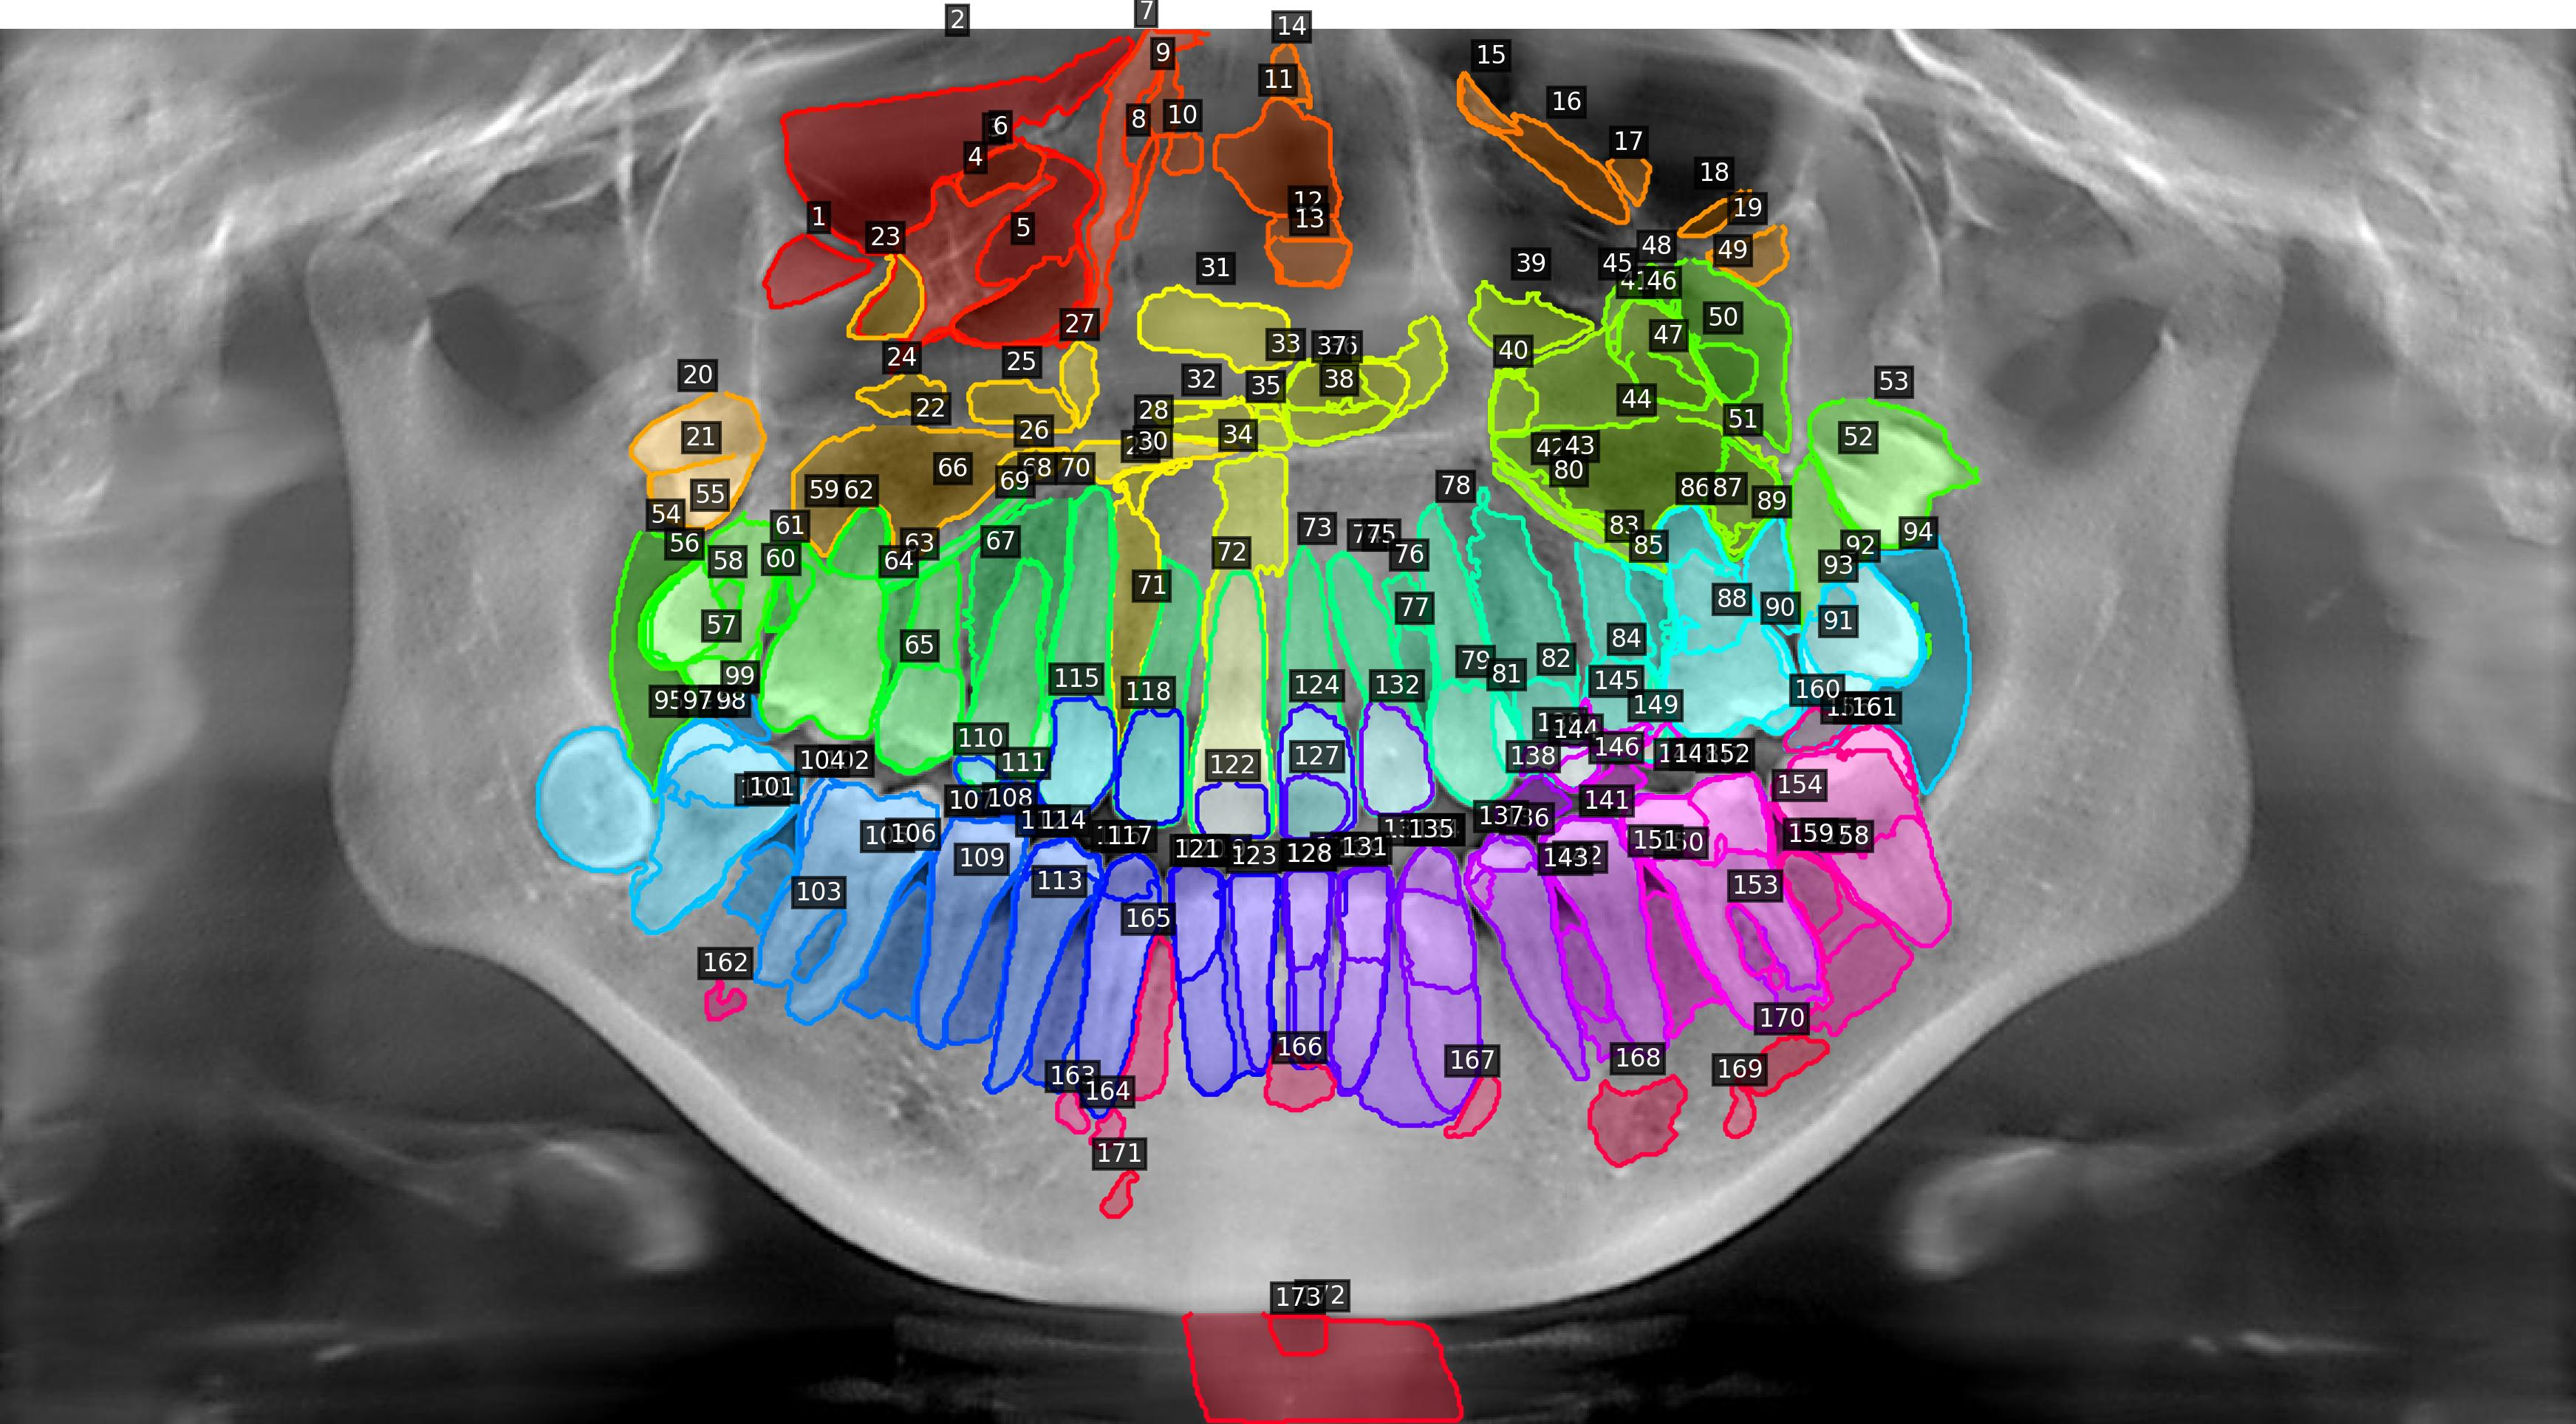


Processing complete! Results saved in /content/resultados/


In [2]:
import torch
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import matplotlib.pyplot as plt
from pathlib import Path
import random
import requests
import os
from tqdm import tqdm
import glob
from IPython.display import display, Image

class ModelDownloader:
    @staticmethod
    def download_file(url, filename):
        response = requests.get(url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024
        progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)

        with open(filename, 'wb') as file:
            for data in response.iter_content(block_size):
                progress_bar.update(len(data))
                file.write(data)
        progress_bar.close()

    @staticmethod
    def download_sam_model():
        model_path = "sam2_h.pth"
        if not os.path.exists(model_path):
            print("Downloading SAM model...")
            url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
            ModelDownloader.download_file(url, model_path)
        return model_path

class DentalSegmentation:
    def __init__(self, device="cuda" if torch.cuda.is_available() else "cpu"):
        self.device = device
        sam_checkpoint = ModelDownloader.download_sam_model()

        self.model = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
        self.model.to(device)

        # Parâmetros otimizados para segmentação dental
        self.mask_generator = SamAutomaticMaskGenerator(
            model=self.model,
            points_per_side=42,            # Aumentado para maior precisão
            pred_iou_thresh=0.78,          # Ajustado para melhor detecção
            stability_score_thresh=0.82,    # Balanceado para evitar oversegmentation
            crop_n_layers=2,               # Melhor para detalhes locais
            crop_n_points_downscale_factor=1, # Máxima resolução
            min_mask_region_area=80,       # Menor para detectar dentes pequenos
            box_nms_thresh=0.5,            # Evitar merge indesejado
            points_per_batch=64            # Processamento em lotes
        )

    def preprocess_image(self, image_path):
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Could not read image: {image_path}")

        # Pré-processamento aprimorado
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # CLAHE mais agressivo para realce de contraste
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)

        # Desfoque seletivo para redução de ruído
        denoised = cv2.medianBlur(enhanced, 3)

        # Realce de bordas adaptativo
        gaussian = cv2.GaussianBlur(denoised, (0, 0), 3.0)
        enhanced = cv2.addWeighted(denoised, 1.8, gaussian, -0.8, 0)

        # Normalização adaptativa
        enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)

        # Equalização de histograma adaptativa
        enhanced = cv2.equalizeHist(enhanced)

        # Converter para RGB
        enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

        return enhanced_rgb, image

    def filter_tooth_masks(self, masks, image_shape):
        height, width = image_shape[:2]
        filtered_masks = []

        # Região dental otimizada
        center_y = height // 2
        center_x = width // 2
        max_distance = min(width, height) * 0.48  # Região dental expandida

        for mask in masks:
            area = mask['area']
            bbox = mask['bbox']

            mask_center_y = bbox[1] + bbox[3]//2
            mask_center_x = bbox[0] + bbox[2]//2

            distance_from_center = np.sqrt(
                (mask_center_x - center_x)**2 +
                (mask_center_y - center_y)**2
            )

            # Critérios refinados
            aspect_ratio = bbox[3] / bbox[2] if bbox[2] != 0 else 0
            relative_area = area / (height * width)

            # Critérios ajustados para dentes
            if (0.0002 < relative_area < 0.02 and      # Faixa de tamanho mais flexível
                0.3 < aspect_ratio < 4.5 and           # Maior variação de formato
                distance_from_center < max_distance and # Região expandida
                bbox[2] > 12 and                       # Largura mínima reduzida
                bbox[3] > 15):                         # Altura mínima reduzida

                filtered_masks.append(mask)

        return filtered_masks

    def merge_overlapping_masks(self, masks):
        if not masks:
            return []

        final_masks = []
        used_masks = set()

        for i, mask1 in enumerate(masks):
            if i in used_masks:
                continue

            current_mask = mask1.copy()
            current_segmentation = current_mask['segmentation'].copy()

            for j, mask2 in enumerate(masks[i+1:], i+1):
                if j in used_masks:
                    continue

                # Sobreposição mais precisa
                intersection = np.logical_and(current_segmentation, mask2['segmentation']).sum()
                union = np.logical_or(current_segmentation, mask2['segmentation']).sum()
                iou = intersection / union

                if iou > 0.65:  # Limiar reduzido para melhor merge
                    used_masks.add(j)
                    current_segmentation = np.logical_or(current_segmentation, mask2['segmentation'])
                    current_mask['segmentation'] = current_segmentation
                    current_mask['area'] = current_segmentation.sum()

            final_masks.append(current_mask)
            used_masks.add(i)

        return final_masks

    def generate_tooth_masks(self, image):
        # Generate initial masks
        masks = self.mask_generator.generate(image)

        # Filter masks based on dental characteristics
        filtered_masks = self.filter_tooth_masks(masks, image.shape)

        # Merge overlapping masks
        merged_masks = self.merge_overlapping_masks(filtered_masks)

        # Sort masks by position (left to right, top to bottom)
        sorted_masks = sorted(merged_masks,
                            key=lambda x: (x['bbox'][1] // 100, x['bbox'][0]))

        return sorted_masks

    def visualize_segmentation(self, image, masks, output_path):
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Generate distinct colors using HSV color space
        colors = []
        for i in range(len(masks)):
            hue = i / len(masks)
            colors.append(plt.cm.hsv(hue)[:3])

        # Create overlay for all masks
        overlay = np.zeros((*image.shape[:2], 4), dtype=np.float32)

        for idx, (mask, color) in enumerate(zip(masks, colors)):
            mask_array = mask['segmentation']

            # Add colored overlay
            overlay_color = np.zeros((*image.shape[:2], 4), dtype=np.float32)
            overlay_color[mask_array] = (*color, 0.3)
            overlay = np.maximum(overlay, overlay_color)

            # Draw contours
            contours = cv2.findContours(
                mask_array.astype(np.uint8),
                cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE
            )[0]

            for contour in contours:
                plt.plot(contour[:, 0, 0], contour[:, 0, 1],
                        color=color, linewidth=1.5)

            # Add tooth number
            bbox = mask['bbox']
            center_x = bbox[0] + bbox[2]/2
            center_y = bbox[1] - 5
            plt.text(center_x, center_y, f"{idx+1}",
                    color='white', fontsize=8, ha='center',
                    bbox=dict(facecolor='black', alpha=0.7, pad=1))

        # Add the complete overlay
        plt.imshow(overlay)

        plt.axis('off')
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=300)
        plt.close()

    def process_directory(self, input_dir, output_dir):
        os.makedirs(output_dir, exist_ok=True)

        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.tif', '*.tiff']
        image_files = []
        for ext in image_extensions:
            image_files.extend(glob.glob(os.path.join(input_dir, ext)))
            image_files.extend(glob.glob(os.path.join(input_dir, ext.upper())))

        print(f"Found {len(image_files)} images to process")

        processed_images = []
        for image_path in tqdm(image_files, desc="Processing images"):
            try:
                filename = os.path.basename(image_path)
                output_path = os.path.join(output_dir, f"segmented_{filename}")

                enhanced_image, original_image = self.preprocess_image(image_path)
                masks = self.generate_tooth_masks(enhanced_image)

                print(f"Found {len(masks)} teeth in {filename}")
                self.visualize_segmentation(original_image, masks, output_path)
                processed_images.append(output_path)

            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
                import traceback
                traceback.print_exc()

        return processed_images

def display_results(image_path):
    """Display the segmented image"""
    display(Image(image_path))

def setup_directories():
    """Setup necessary directories"""
    os.makedirs("/content/img", exist_ok=True)
    os.makedirs("/content/resultados", exist_ok=True)

def main():
    # Setup directories
    setup_directories()

    print("\nInitializing dental segmentation...")

    # Initialize segmentation model
    segmenter = DentalSegmentation()

    # Set directories
    input_dir = "/content/img"
    output_dir = "/content/resultados"

    print("\nStarting image processing...")
    # Process all images and get list of processed images
    processed_images = segmenter.process_directory(input_dir, output_dir)

    print("\nDisplaying processed images:")
    for image_path in processed_images:
        print(f"\nDisplaying: {os.path.basename(image_path)}")
        display_results(image_path)

    print("\nProcessing complete! Results saved in /content/resultados/")

if __name__ == "__main__":
    main()

In [1]:
!pip install segment-anything
!pip install torch torchvision
!pip install opencv-python matplotlib requests tqdm